## Explore map

Este codigo explora un rectangulo y obtiene todos los posibles negocios en el area minimizando el numero de consultas

Disclaimer: mientras mas pequeño el radio de los circulos se logra mejor cobertura del mapa pero tambien aumenta el numero de consultas a la API

### Librerias necesarias 
folium geopandas shapely.geometry matplotlib 

In [16]:
import folium
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

In [17]:
"""Esta funcion recibe un rango de latitudes y longitudes y un radio de busqueda
y devuelve los puntos del mapa que minimizan el numero de consultas a la API de Google Places.

Para ello dividimos el mapa en una reticula hexagonal donde R sera la distacia del centro al vertice
de cada hexagono.
"""

def get_zones(R, lat_i, lat_f, lon_i, lon_f):
   
    dx = R * math.sqrt(3)  # distancia entre centros en la misma fila (horizontal)
    dy = 1.5 * R     # distancia vertical entre centros en filas alternadas

    zones = []

    lat = lat_i
    row = 0
    while lat <= lat_f:
        # desplazamiento en columnas: pares sin offset, impares con dx/2
        offset = 0 if row % 2 == 0 else dx / 2
        lon = lon_i + offset

        while lon <= lon_f:
            zones.append((lat, lon))
            lon += dx

        lat += dy
        row += 1

    return zones

In [33]:
# Parámetros
R = 0.003  # Aproximadamente 1 km entre centros
lat_i, lat_f = 40.48, 40.92
lon_i, lon_f = -74.28, -73.7

centros = get_zones(R, lat_i, lat_f, lon_i, lon_f)

C:\Users\NoxiePC\AppData\Local\Temp\ipykernel_4908\1349036806.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within_nyc = points_gdf[points_gdf.within(nyc.unary_union)]


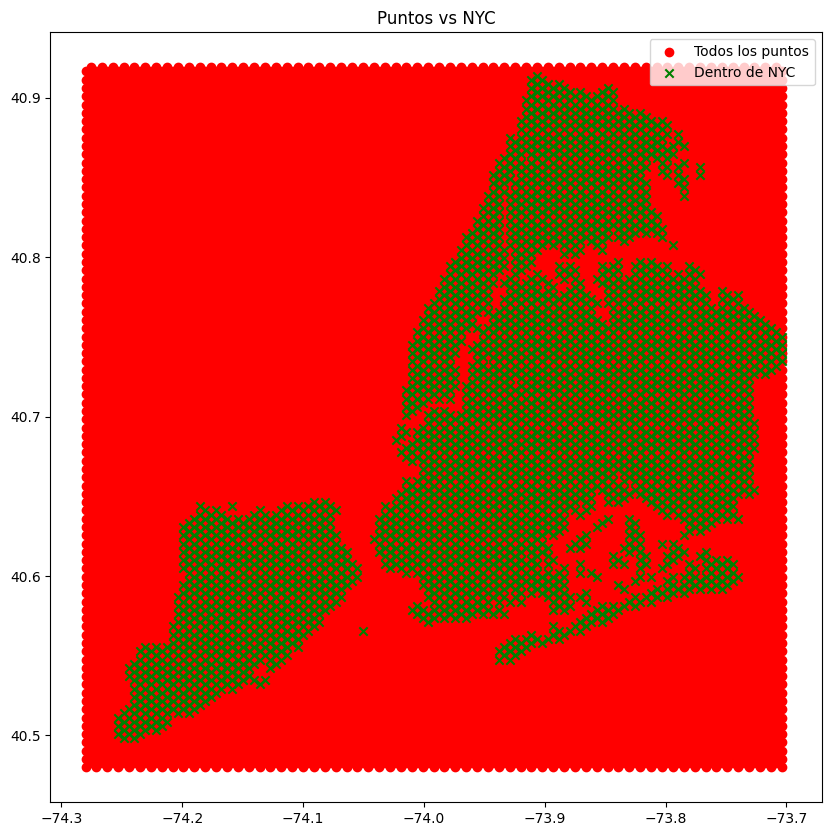

In [47]:
centros = get_zones(R, lon_i, lon_f, lat_i, lat_f)

import os
import sys
sys.path.append(os.path.abspath("../src"))


from path_manager import get_data_paths

paths = get_data_paths()  # Ahora sí se define correctamente

path_raw = paths['raw']
path_interim = paths['interim']

file_path = os.path.join(path_raw, "coord_nyc/nybb.shp")
# Cargar y transformar shapefile
nyc = gpd.read_file(file_path).to_crs(epsg=4326)

# Crear GeoDataFrame de centros
points_gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in centros],  # lon, lat está bien
    crs="EPSG:4326"
)

# Ver qué puntos están dentro
points_within_nyc = points_gdf[points_gdf.within(nyc.unary_union)]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
nyc.plot(ax=ax, color='lightblue', edgecolor='black')
points_gdf.plot(ax=ax, color='red', marker='o', label='Todos los puntos')
points_within_nyc.plot(ax=ax, color='green', marker='x', label='Dentro de NYC')
plt.legend()
plt.title("Puntos vs NYC")
plt.show()


In [29]:
m = folium.Map(location=[(lat_i + lat_f) / 2, (lon_i + lon_f) / 2], zoom_start=12)

# Dibujar un círculo de 1 km sobre cada punto
for point in points_within_nyc.geometry:
    folium.Circle(
        location=[point.y, point.x],  # lat, lon
        radius=300,  # metros
        color='red',
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

m


In [ ]:
import requests
import json
import urllib.parse
import pandas as pd
import time
import random

def obtener_restaurantes_osm_2(lat, lon, radio=300):
    overpass_url = "http://overpass-api.de/api/interpreter"
    
    query = f"""
    [out:json][timeout:60];
    (
      node["amenity"~"restaurant|cafe|bar|pub|fast_food|ice_cream"](around:{radio},{lat},{lon});
      way["amenity"~"restaurant|cafe|bar|pub|fast_food|ice_cream"](around:{radio},{lat},{lon});
      relation["amenity"~"restaurant|cafe|bar|pub|fast_food|ice_cream"](around:{radio},{lat},{lon});
      node["cuisine"~"pizza|sushi|seafood|steak|chicken|sandwich|coffee|tea"](around:{radio},{lat},{lon});
      way["cuisine"~"pizza|sushi|seafood|steak|chicken|sandwich|coffee|tea"](around:{radio},{lat},{lon});
      node["destination"~"restaurant|cafe|food|diner|bistro|brunch"](around:{radio},{lat},{lon});
      way["destination"~"restaurant|cafe|food|diner|bistro|brunch"](around:{radio},{lat},{lon});
      node["name"~"pizza|taqueria|pizzeria|coffee|tea|sushi|seafood|bistro|steak|chicken|sandwich|brunch|diner|grill|bakery",i](around:{radio},{lat},{lon});
      way["name"~"pizza|taqueria|pizzeria|coffee|tea|sushi|seafood|bistro|steak|chicken|sandwich|brunch|diner|grill|bakery",i](around:{radio},{lat},{lon});
    );
    out center tags 100;
    """

    try:
        encoded_query = urllib.parse.urlencode({'data': query}, quote_via=urllib.parse.quote)
        response = requests.get(overpass_url, params=encoded_query, timeout=60)
        response.raise_for_status()
        data = response.json()

        restaurantes = []
        seen_ids = set()
        for element in data['elements']:
            element_id = element.get('id')
            if element_id in seen_ids:
                continue
            seen_ids.add(element_id)

            tags = element.get('tags', {})
            element_lat = element.get('lat', element.get('center', {}).get('lat'))
            element_lon = element.get('lon', element.get('center', {}).get('lon'))

            categories = []
            if tags.get('amenity'):
                categories.append(tags['amenity'])
            if tags.get('cuisine'):
                categories.extend(tags['cuisine'].split(';'))
            if tags.get('destination'):
                categories.append(tags['destination'])

            restaurante = {
                "gmap_id": element_id,
                "type": element.get('type'),
                "name": tags.get('name', 'Sin nombre'),
                "address": f"{tags.get('addr:street', '')} {tags.get('addr:housenumber', '')}, {tags.get('addr:city', '')}, {tags.get('addr:state', '')} {tags.get('addr:postcode', '')}".strip() or "Desconocida",
                "description": tags.get('description', 'Sin descripción'),
                "latitude": element_lat,
                "longitude": element_lon,
                "category": categories or ['restaurant'],
                "price": tags.get('price', tags.get('price:range', None)),
                "hours": tags.get('opening_hours', None),
                "state": tags.get('addr:state', None),
                "url": tags.get('website', None),
                "MISC": {
                    "cuisine": tags.get('cuisine', None),
                    "wheelchair": tags.get('wheelchair', None),
                    "takeaway": tags.get('takeaway', None),
                    "delivery": tags.get('delivery', None),
                    "phone": tags.get('phone', tags.get('contact:phone', None)),
                    "email": tags.get('email', tags.get('contact:email', None)),
                    "smoking": tags.get('smoking', None),
                    "access": tags.get('access', None),
                    "destination": tags.get('destination', None),
                    "brand": tags.get('brand', None),
                    "reservation": tags.get('reservation', None),
                    "outdoor_seating": tags.get('outdoor_seating', None),
                    "internet_access": tags.get('internet_access', None),
                    "other_tags": {k: v for k, v in tags.items() if k not in [
                        'name', 'addr:street', 'addr:housenumber', 'addr:city', 'addr:state', 'addr:postcode',
                        'description', 'amenity', 'cuisine', 'destination', 'price', 'price:range', 'opening_hours',
                        'wheelchair', 'takeaway', 'delivery', 'website', 'phone', 'contact:phone', 'email',
                        'contact:email', 'smoking', 'access', 'brand', 'reservation', 'outdoor_seating', 'internet_access'
                    ]}
                }
            }

            restaurantes.append(restaurante)

        return restaurantes
    
    except requests.exceptions.HTTPError as http_err:
        print(f"Error HTTP en ({lat}, {lon}): {http_err}")
        try:
            print(f"Respuesta del servidor: {response.text}")
        except NameError:
            print("No se recibió respuesta del servidor.")
        return []
    except Exception as e:
        print(f"Error general en ({lat}, {lon}): {e}")
        return []

def guardar_resultados(restaurantes, filename):
    """Guarda los resultados en un archivo JSON."""
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(restaurantes, f, indent=2, ensure_ascii=False)

def mostrar_resultados(restaurantes, limite=5):
    """Muestra los primeros resultados de forma legible."""
    for r in restaurantes[:limite]:
        print(f"Nombre: {r['name']}")
        print(f"Dirección: {r['address']}")
        print(f"Categorías: {r['category']}")
        print(f"Cocina: {r['MISC']['cuisine']}")
        print(f"Horarios: {r['hours']}")
        print(f"Web: {r['url']}")
        print("-" * 50)

def generar_dataset(restaurantes, output_file):
    """Genera un dataset en CSV a partir de los resultados."""
    if not restaurantes:
        print("No hay datos para generar el dataset.")
        return pd.DataFrame()
    
    df = pd.DataFrame(restaurantes)
    
    # Serializar listas y diccionarios
    df['category'] = df['category'].apply(lambda x: ';'.join(x) if isinstance(x, list) else x)
    df['other_tags'] = df['MISC'].apply(lambda x: ';'.join([f'{k}={v}' for k, v in x['other_tags'].items()]) if x['other_tags'] else None)
    
    # Renombrar y eliminar columnas
    df = df.rename(columns={
        'MISC_cuisine': 'cuisine',
        'MISC_wheelchair': 'wheelchair',
        'MISC_takeaway': 'takeaway',
        'MISC_delivery': 'delivery',
        'MISC_phone': 'phone',
        'MISC_email': 'email',
        'MISC_smoking': 'smoking',
        'MISC_access': 'access',
        'MISC_destination': 'destination',
        'MISC_brand': 'brand',
        'MISC_reservation': 'reservation',
        'MISC_outdoor_seating': 'outdoor_seating',
        'MISC_internet_access': 'internet_access'
    })
    df = df.drop(columns=['MISC'], errors='ignore')
    df = df.drop_duplicates(subset=['gmap_id'], keep='first')
    
    # Guardar como parquet
    df.to_parquet(output_file, index=False)
    return df

In [ ]:
import geopandas as gpd
import random

resultados = []

for punto in points_within_nyc.geometry:
    lon, lat = punto.x, punto.y
    data = obtener_restaurantes_osm_2(lat, lon, radio=300)
    resultados.extend(data)
    
    time.sleep(random.uniform(0.5, 1.5))  # espera entre requests para no abusar

# Convertir resultados a DataFrame y guardar

df = generar_dataset(resultados, output_file=os.path.join(path_interim, "restaurantes_nyc_overpass.parquet"))
print("Listo. Restaurantes guardados en CSV.")
print(f"Dataset generado con {len(df)} filas y {len(df.columns)} columnas")

Listo. Restaurantes guardados en CSV.
Dataset generado con 21664 filas y 13 columnas
